In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lu, solve_triangular
import yfinance as yf  # To fetch financial data


In [2]:
# Fetching real-time data for the S&P 500 E-mini Futures, using an equivalent ETF 'SPY'
data = yf.download('SPY', period='1mo', interval='1h')
# Assuming 'Close' price is used for the analysis
close_prices = data['Close']


[*********************100%%**********************]  1 of 1 completed


In [4]:
# Super Smoother Filter function
def super_smoother(series, period):
    # Constants for the filter calculation
    a1 = np.exp(-1.414 * np.pi / period)
    b1 = 2 * a1 * np.cos(1.414 * np.pi / period)
    c2 = b1
    c3 = -a1 * a1
    c1 = 1 - c2 - c3

    # Preallocate the output series with the same initial value as input
    filtered_series = np.full_like(series, series.iloc[0])

    # Apply the filter to the series
    for i in range(2, len(series)):
        filtered_series[i] = c1 * series.iloc[i] + c2 * filtered_series[i - 1] + c3 * filtered_series[i - 2]

    return pd.Series(filtered_series, index=series.index)

# Applying the Super Smoother Filter to the closing prices
filtered_close_prices = super_smoother(close_prices, period=10)


In [5]:
# Number of periods and order of the polynomial regression
n_periods = 100
order = 2

# X values are simply the index of the period
x_vals = np.arange(1, n_periods + 1)

# Y values are the last 'n' filtered close prices
y_vals = filtered_close_prices[-n_periods:]


In [10]:
# Create the Vandermonde matrix for X
X = np.vander(x_vals, N=order + 1, increasing=True)

# Perform LU decomposition on the transpose of X to get a square matrix for decomposition
P, L, U = lu(X.T @ X)

# Solve the linear system for the coefficients using the transpose of X
y = solve_triangular(L, P.T @ (X.T @ y_vals), lower=True)
coefs = solve_triangular(U, y)

# Calculate the regression values
regression_values = X @ coefs


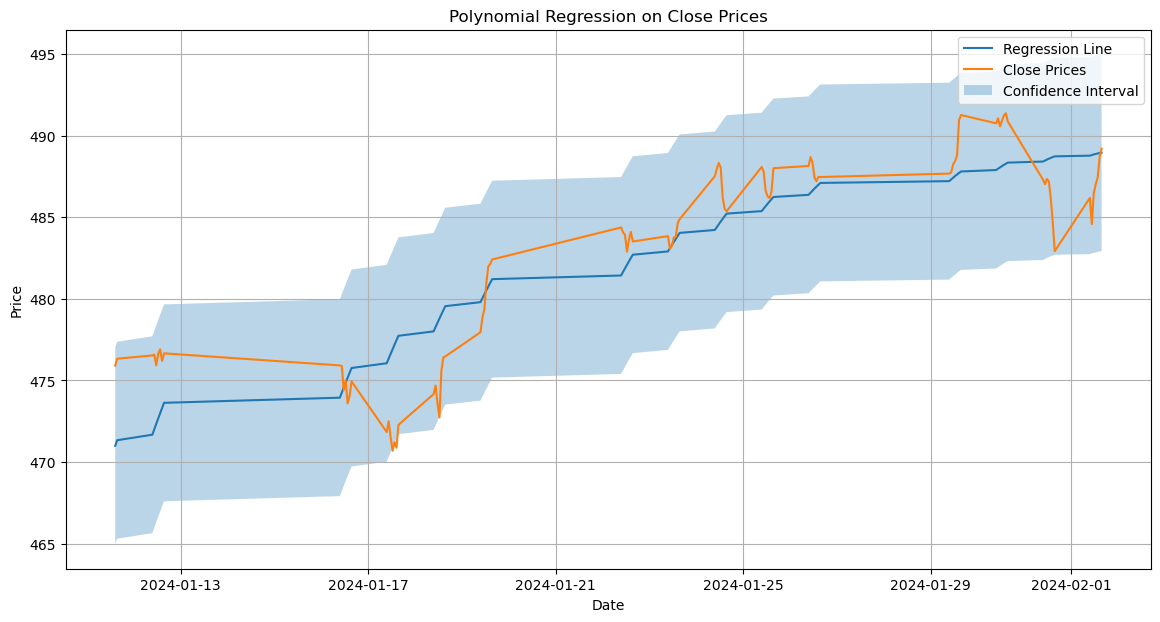

In [11]:
# Calculate the regression values
regression_values = X @ coefs

# Plot the regression line and the close prices
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index[-n_periods:], regression_values, label='Regression Line')
plt.plot(close_prices.index[-n_periods:], close_prices[-n_periods:], label='Close Prices')
plt.fill_between(close_prices.index[-n_periods:], regression_values - np.std(y_vals), regression_values + np.std(y_vals), alpha=0.3, label='Confidence Interval')

# Customize the plot with a grid, legend, and labels
plt.grid(True)
plt.legend()
plt.title('Polynomial Regression on Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
